In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from google.colab import drive

Load dataset

In [2]:
def load_images_labels(dataset_path):
    images = []
    labels = []
    for label_folder in os.listdir(dataset_path):
        for file in os.listdir(os.path.join(dataset_path, label_folder)):
            image_path = os.path.join(dataset_path, label_folder, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))  # Resize to 128x128
            images.append(image)
            labels.append(label_folder)
    images = np.array(images)
    labels = np.array(pd.factorize(labels)[0])  # Encoding labels
    return images, labels

In [3]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Fold 1/Train'  # Update path as needed
images, labels = load_images_labels(dataset_path)

Mounted at /content/drive


<ipython-input-2-3bb512fabe6a>:12: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = np.array(pd.factorize(labels)[0])  # Encoding labels


Train-validation-test split


In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Normalize images


In [5]:
# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


Convert labels to categorical




In [6]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Building a CNN model with early stopping


In [7]:
def build_cnn_model(input_shape=(128, 128, 3), num_classes=3):  # Adjust `num_classes` as needed
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])
    return model

# Instantiate the CNN model
cnn_model = build_cnn_model(num_classes=y_train.shape[1])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,517,574 (24.86 MB)

 Trainable params: 6,517,574 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

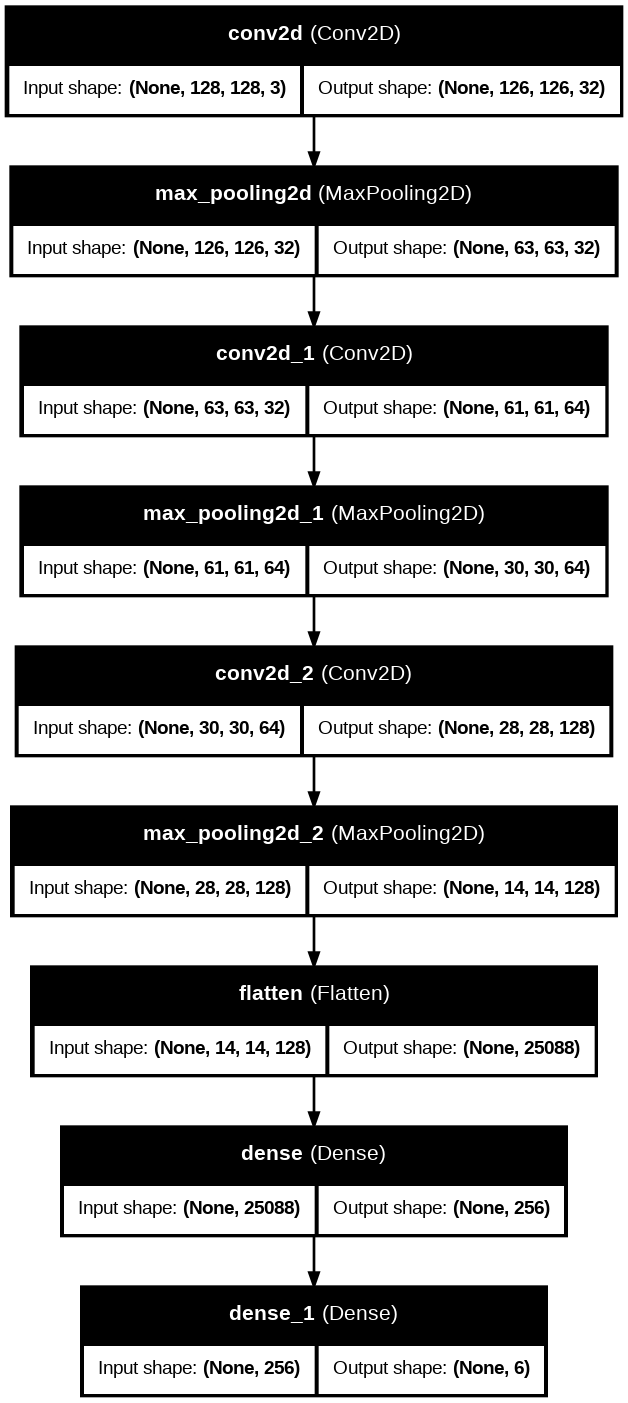

In [8]:
plot_model(
    cnn_model,
    to_file="cnn.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    dpi=96
)

Defining early stopping callback

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

Training the CNN model with early stopping

In [10]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping],  # Include early stopping in the callbacks
    batch_size=32
)

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.3316 - loss: 1.7150 - val_accuracy: 0.4879 - val_loss: 1.3006
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5434 - loss: 1.2226 - val_accuracy: 0.6417 - val_loss: 0.9818
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6890 - loss: 0.8564 - val_accuracy: 0.6825 - val_loss: 0.8636
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7732 - loss: 0.6365 - val_accuracy: 0.7598 - val_loss: 0.7508
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8531 - loss: 0.4070 - val_accuracy: 0.7963 - val_loss: 0.6920
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8982 - loss: 0.2936 - val_accuracy: 0.7872 - val_loss: 0.7821
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9263 - loss: 0.2092 - val_accuracy: 0.7955 - val_loss: 0.8321
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9443 - loss: 0.1616 - val_acc

Evaluating the CNN model on test data

In [11]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy of CNN Model: {test_accuracy:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7559 - loss: 0.8278
Test Accuracy of CNN Model: 0.7593


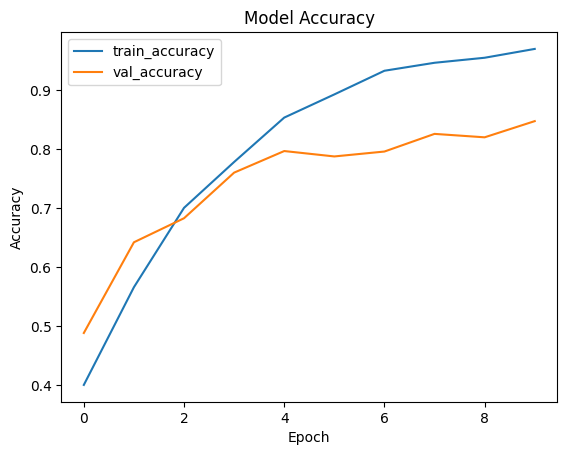

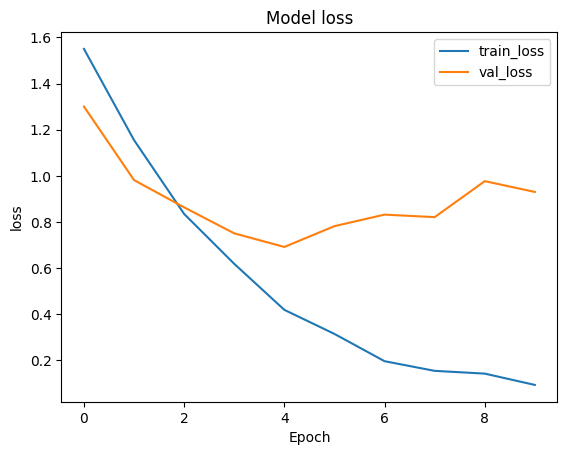

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

 Using VGG16 as feature extractor for traditional ML models

In [13]:
feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor.trainable = False  # Freeze the layers


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
def extract_features(model, data):
    return model.predict(data).reshape(data.shape[0], -1)

Extracting features from VGG16

In [15]:
X_train_features = extract_features(feature_extractor, X_train)
X_val_features = extract_features(feature_extractor, X_val)
X_test_features = extract_features(feature_extractor, X_test)

151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


Normalizing the extracted features

In [16]:
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_val_features = scaler.transform(X_val_features)
X_test_features = scaler.transform(X_test_features)

Defining classifier models

In [17]:
classifiers = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='linear', C=1, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

Training and evaluating the classifiers on extracted features

In [20]:
from sklearn.metrics import classification_report

class_names =['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles','Monkeypox']
# Assuming y_test_labels contains the true labels and y_test is one-hot encoded
y_test_labels = np.argmax(y_test, axis=1)

# Loop through classifiers and generate classification reports
for name, clf in classifiers.items():
    clf.fit(X_train_features, np.argmax(y_train, axis=1))  # Train the classifier
    y_pred = clf.predict(X_test_features)  # Predict on test set

    # Generate classification report
    report = classification_report(y_test_labels, y_pred, target_names=class_names)

    print(f"Model: {name}")
    print(report)
    print("-" * 50)

Model: Naive Bayes
              precision    recall  f1-score   support

  Chickenpox       0.25      0.27      0.26       119
      Cowpox       0.70      0.30      0.43       574
        HFMD       0.51      0.61      0.56       231
     Healthy       0.23      0.71      0.35       134
     Measles       0.36      0.51      0.42       133
   Monkeypox       0.70      0.56      0.62       313

    accuracy                           0.46      1504
   macro avg       0.46      0.49      0.44      1504
weighted avg       0.56      0.46      0.47      1504

--------------------------------------------------
Model: SVM
              precision    recall  f1-score   support

  Chickenpox       0.88      0.82      0.85       119
      Cowpox       0.88      0.91      0.89       574
        HFMD       0.84      0.87      0.86       231
     Healthy       0.85      0.83      0.84       134
     Measles       0.92      0.89      0.90       133
   Monkeypox       0.91      0.87      0.89       3

Testing few samples

In [21]:
test_cases = X_test_features[:5]
expected_labels = y_test_labels[:5]

for name, clf in classifiers.items():
    predictions = clf.predict(test_cases)
    print(f"Test case predictions for {name}: {predictions}")
    print(f"Expected labels: {expected_labels}")
    print("-" * 30)

Test case predictions for Naive Bayes: [0 3 2 1 0]
Expected labels: [1 4 2 2 1]
------------------------------
Test case predictions for SVM: [1 4 2 1 1]
Expected labels: [1 4 2 2 1]
------------------------------
Test case predictions for KNN: [1 4 2 3 1]
Expected labels: [1 4 2 2 1]
------------------------------
Test case predictions for Random Forest: [1 4 2 1 1]
Expected labels: [1 4 2 2 1]
------------------------------


In [22]:
cnn_model.save('/content/drive/MyDrive/classifierCNN.keras')